# 2CSSID Workshop02. Data preparation & Model evaluation

<p style='text-align: right;font-style: italic; color: red;'>Designed by: Mr. Abdelkrime Aries</p>


In [70]:
# Activate the lines to install unfound modules
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install imblearn

In [71]:
import numpy  as np
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('2.3.3', '2.3.3', '3.10.7')

In [72]:
import sqlite3
from imblearn.under_sampling import ClusterCentroids, TomekLinks
from imblearn.over_sampling import SMOTE

In [73]:
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree         import DecisionTreeClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.ensemble     import RandomForestClassifier
from sklearn.metrics      import accuracy_score
from sklearn.metrics      import f1_score
import timeit

## 1. Business understanding

1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF) with softmax function.
    - ...
1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF, Other) with softmax function.
    - ...
1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF) with sigmoid function.
    - ...
1. One model having the 5 outputs (TWF, HDF, PWF, OSF, RNF, Other) with sigmoid function.
    - it works !
1. Two models, one for binary classification for failure yes/no. In case of failure, we train a second model to detect the
type similar to that of first solution.
    - ...
1. the same thing, but the second model is similar to that of the third solution.
    - it works !

## 2. Data understanding

### 2.1. Collecting initial data

In [74]:
# read data from csv file
df_csv = pd.read_csv('data/ai4i2020a.csv')
df_csv.shape

(5983, 9)

In [75]:
df_csv.describe()

,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
count,5972.000000,5978.000000,5978.000000,5982.000000,5980.000000,5983.000000
mean,27.165941,36.769036,1540.695718,39.883835,108.735452,0.039612
std,2.285344,1.666296,182.795413,9.899791,63.852593,0.195063
min,22.150000,32.550000,1168.000000,3.800000,0.000000,0.000000
25%,25.150000,35.450000,1423.000000,33.200000,54.000000,0.000000
50%,27.250000,36.550000,1504.000000,40.000000,109.000000,0.000000
75%,29.150000,37.950000,1613.000000,46.700000,163.000000,0.000000
max,31.350000,40.650000,2886.000000,76.200000,251.000000,1.000000


In [76]:
# read data from sqlite database
conn = sqlite3.connect('data/ai4i2020b.sqlite')
df_sql = pd.read_sql_query("SELECT * FROM failure", conn)

### 2.2. Describing data

In [77]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               5983 non-null   object 
 1   Type                     5983 non-null   object 
 2   Air temperature [C]      5972 non-null   float64
 3   Process temperature [C]  5978 non-null   float64
 4   Rotational speed [rpm]   5978 non-null   float64
 5   Torque [Nm]              5982 non-null   float64
 6   Tool wear [min]          5980 non-null   float64
 7   Machine failure          5983 non-null   int64  
 8   Failure type             5983 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 420.8+ KB


In [78]:
df_csv['Rotational speed [rpm]'] = df_csv['Rotational speed [rpm]'].astype('Int64')
df_csv['Tool wear [min]'] = df_csv['Tool wear [min]'].astype('Int64')
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               5983 non-null   object 
 1   Type                     5983 non-null   object 
 2   Air temperature [C]      5972 non-null   float64
 3   Process temperature [C]  5978 non-null   float64
 4   Rotational speed [rpm]   5978 non-null   Int64  
 5   Torque [Nm]              5982 non-null   float64
 6   Tool wear [min]          5980 non-null   Int64  
 7   Machine failure          5983 non-null   int64  
 8   Failure type             5983 non-null   object 
dtypes: Int64(2), float64(3), int64(1), object(3)
memory usage: 432.5+ KB


In [79]:
df_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    5019 non-null   object 
 1   Air_Temperature_K     5019 non-null   float64
 2   ProcessTemperature_K  5019 non-null   object 
 3   Rotational_speed      5019 non-null   object 
 4   Torque                5019 non-null   object 
 5   Tool_wear             5019 non-null   object 
 6   Failure               5019 non-null   int64  
 7   TWF                   5019 non-null   int64  
 8   HDF                   5019 non-null   int64  
 9   PWF                   5019 non-null   int64  
 10  OSF                   5019 non-null   int64  
 11  RNF                   5019 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 470.7+ KB


In [80]:
df_sql.head()

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
0,M19859,303.7,312.9,1532,41.3,32,0,0,0,0,0,0
1,L52180,303.7,312.8,1832,23.6,35,0,0,0,0,0,0
2,M19861,303.6,312.7,2174,17.6,37,0,0,0,0,0,0
3,L52182,303.7,312.8,1627,31.7,40,0,0,0,0,0,0
4,L52183,303.7,312.8,1437,51.3,42,0,0,0,0,0,0


In [81]:
# Convert columns to appropriate data types
df_sql['ProcessTemperature_K'] = df_sql['ProcessTemperature_K'].replace('', np.nan).astype('float')
df_sql['Rotational_speed'] = df_sql['Rotational_speed'].replace('', np.nan).astype('float')
df_sql['Torque'] = df_sql['Torque'].replace('', np.nan).astype('float')
df_sql['Tool_wear'] = df_sql['Tool_wear'].replace('', np.nan).astype('float')

df_sql['ProcessTemperature_K'] = df_sql['ProcessTemperature_K'].astype('Float64')
df_sql['Rotational_speed'] = df_sql['Rotational_speed'].astype('Int64')
df_sql['Torque'] = df_sql['Torque'].astype('Float64')
df_sql['Tool_wear'] = df_sql['Tool_wear'].astype('Int64')
df_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    5019 non-null   object 
 1   Air_Temperature_K     5019 non-null   float64
 2   ProcessTemperature_K  5014 non-null   Float64
 3   Rotational_speed      5016 non-null   Int64  
 4   Torque                5013 non-null   Float64
 5   Tool_wear             5017 non-null   Int64  
 6   Failure               5019 non-null   int64  
 7   TWF                   5019 non-null   int64  
 8   HDF                   5019 non-null   int64  
 9   PWF                   5019 non-null   int64  
 10  OSF                   5019 non-null   int64  
 11  RNF                   5019 non-null   int64  
dtypes: Float64(2), Int64(2), float64(1), int64(6), object(1)
memory usage: 490.3+ KB


/tmp/ipykernel_7520/3836625184.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sql['ProcessTemperature_K'] = df_sql['ProcessTemperature_K'].replace('', np.nan).astype('float')
/tmp/ipykernel_7520/3836625184.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sql['Rotational_speed'] = df_sql['Rotational_speed'].replace('', np.nan).astype('float')
/tmp/ipykernel_7520/3836625184.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitl

In [82]:
df_csv.describe()

,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
count,5972.000000,5978.000000,5978.0,5982.000000,5980.0,5983.000000
mean,27.165941,36.769036,1540.695718,39.883835,108.735452,0.039612
std,2.285344,1.666296,182.795413,9.899791,63.852593,0.195063
min,22.150000,32.550000,1168.0,3.800000,0.0,0.000000
25%,25.150000,35.450000,1423.0,33.200000,54.0,0.000000
50%,27.250000,36.550000,1504.0,40.000000,109.0,0.000000
75%,29.150000,37.950000,1613.0,46.700000,163.0,0.000000
max,31.350000,40.650000,2886.0,76.200000,251.0,1.000000


In [83]:
df_sql.describe()

,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
count,5019.000000,5014.0,5016.0,5013.0,5017.0,5019.000000,5019.000000,5019.000000,5019.000000,5019.000000,5019.000000
mean,299.188643,309.552333,1535.59051,40.164692,107.365358,0.024308,0.005579,0.001793,0.009364,0.012154,0.002391
std,16.336889,16.388577,173.434366,10.006983,63.381024,0.154018,0.074490,0.042312,0.096325,0.109583,0.048843
min,24.850000,35.55,1181.0,9.7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,298.700000,309.6,1423.0,33.3,53.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,300.300000,310.6,1501.0,40.2,107.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,301.100000,311.5,1609.0,46.8,162.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,304.500000,313.8,2710.0,76.6,253.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [84]:
df_csv[df_csv["Type"] == "L"].describe()

,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
count,3588.000000,3594.000000,3593.0,3595.000000,3594.0,3595.000000
mean,27.171433,36.767028,1541.608127,39.894214,109.676683,0.043672
std,2.266254,1.648043,186.036898,10.025461,64.124618,0.204392
min,22.150000,32.550000,1192.0,3.800000,0.0,0.000000
25%,25.150000,35.450000,1422.0,33.150000,55.0,0.000000
50%,27.150000,36.650000,1504.0,40.000000,111.0,0.000000
75%,29.150000,37.950000,1614.0,46.800000,164.0,0.000000
max,31.350000,40.650000,2886.0,71.600000,251.0,1.000000


In [85]:
df_csv.columns

Index(['Product ID', 'Type', 'Air temperature [C]', 'Process temperature [C]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'Failure type'],
      dtype='object')

In [86]:
df_csv['Failure type'].unique(), df_csv['Failure type'].value_counts()

(array(['NOT', 'PWF', 'TWF', 'OSF', 'RNF', 'OTHER', 'HDF'], dtype=object),
 Failure type
 NOT      5733
 HDF       106
 PWF        56
 OSF        46
 TWF        23
 RNF        13
 OTHER       6
 Name: count, dtype: int64)

In [87]:
df_sql.columns

Index(['ID', 'Air_Temperature_K', 'ProcessTemperature_K', 'Rotational_speed',
       'Torque', 'Tool_wear', 'Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

### 2.3. Exploring data

In [88]:
# Distribution of Machine failure variable for csv data
cls, freq = np.unique(df_csv['Machine failure'], return_counts=True)
cls, freq

(array([0, 1]), array([5746,  237]))

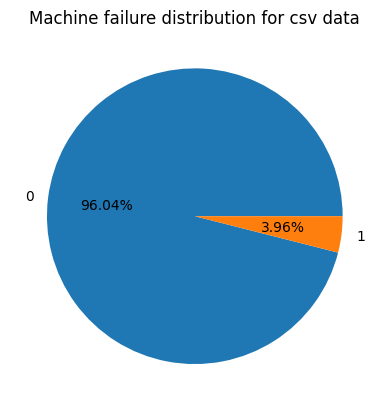

In [89]:
plt.title("Machine failure distribution for csv data")
plt.pie(freq, labels=cls, autopct='%1.2f%%')
plt.show()

In [90]:
# Destribution of machine failure cariable in sql data
cls, freq = np.unique(df_sql['Failure'], return_counts=True)
cls, freq

(array([0, 1]), array([4897,  122]))

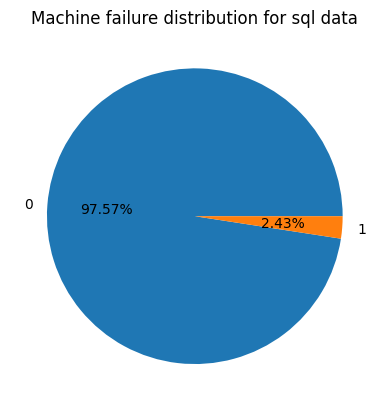

In [91]:
plt.title("Machine failure distribution for sql data")
plt.pie(freq, labels=cls, autopct='%1.2f%%')
plt.show()

In [92]:
cls, freq = np.unique(df_csv[df_csv['Machine failure']==1]['Failure type'], return_counts=True)
cls, freq

(array(['HDF', 'OSF', 'OTHER', 'PWF', 'TWF'], dtype=object),
 array([106,  46,   6,  56,  23]))

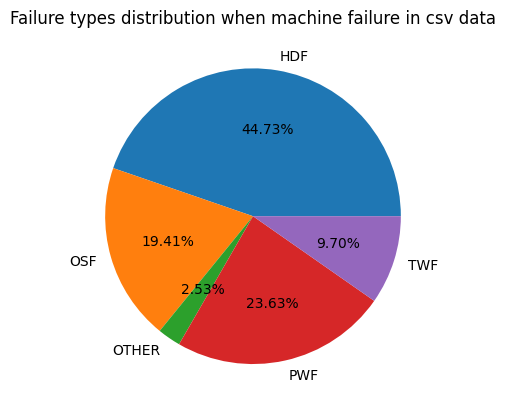

In [93]:
plt.title('Failure types distribution when machine failure in csv data')
plt.pie(freq, labels=cls, autopct='%1.2f%%')
plt.show()

In [94]:
df_sql[df_sql.Failure==1].sample(10)

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
402,M20261,302.60,312.3,1454,54.8,253,1,1,0,0,1,0
2927,L55106,300.70,311.9,1335,57.1,194,1,0,0,0,1,0
5014,L51823,30.05,38.25,1324,54.2,228,1,0,1,0,1,0
5013,L51822,30.05,38.25,1238,54.6,226,1,0,1,0,1,0
2998,M22857,301.00,312.2,2710,9.7,143,1,0,0,1,0,0
3507,L55686,298.40,309.6,1710,27.3,163,1,0,0,0,0,0
3196,L55375,299.40,310.8,1376,53.9,215,1,0,0,0,1,0
1760,L53939,301.70,311.0,1441,44.3,208,1,1,0,0,0,0
3691,L55870,297.10,308.5,1323,44.4,207,1,1,0,0,0,0
2510,L54689,300.60,311.9,1372,60.1,212,1,0,0,0,1,0


In [95]:
freq = []
cls_sql = cls.tolist()
cls_sql.append('RNF')
print(cls_sql)
other = df_sql['Failure']
for c in cls_sql:
    if c != "OTHER":
        freq.append((df_sql['Failure'] * df_sql[c]).sum())
        print('before other sum:', other.sum())
        other = other * (1-df_sql[c])
        print('after other sum:', other.sum())

freq.insert(np.where(cls == "OTHER")[0][0], other.sum())




['HDF', 'OSF', 'OTHER', 'PWF', 'TWF', 'RNF']
before other sum: 122
after other sum: 113
before other sum: 113
after other sum: 58
before other sum: 58
after other sum: 28
before other sum: 28
after other sum: 5
before other sum: 5
after other sum: 5


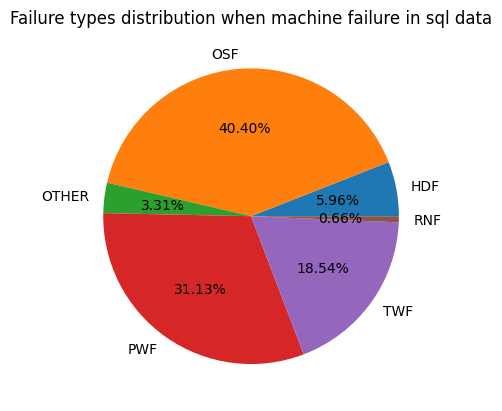

In [96]:
plt.title('Failure types distribution when machine failure in sql data')
plt.pie(freq, labels=cls_sql, autopct='%1.2f%%')
plt.show()

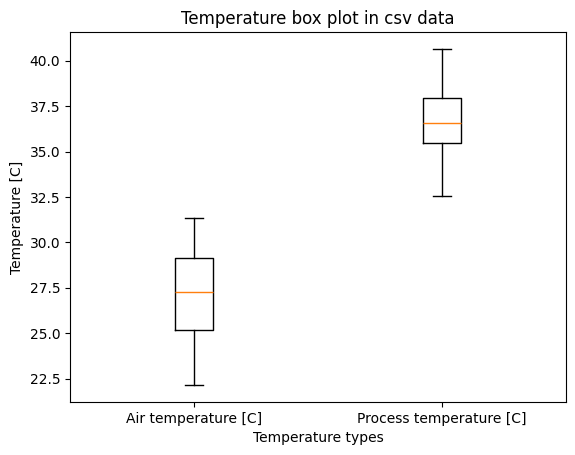

In [97]:
# draw bow plot for temperature variable in csv data
idx = df_csv[['Air temperature [C]', 'Process temperature [C]']].notnull()

plt.title('Temperature box plot in csv data')
plt.boxplot([
    df_csv['Air temperature [C]'].loc[idx['Air temperature [C]']],
    df_csv['Process temperature [C]'].loc[idx['Process temperature [C]']]
], 
tick_labels=['Air temperature [C]', 'Process temperature [C]'])
plt.xlabel('Temperature types')
plt.ylabel('Temperature [C]')
plt.show()


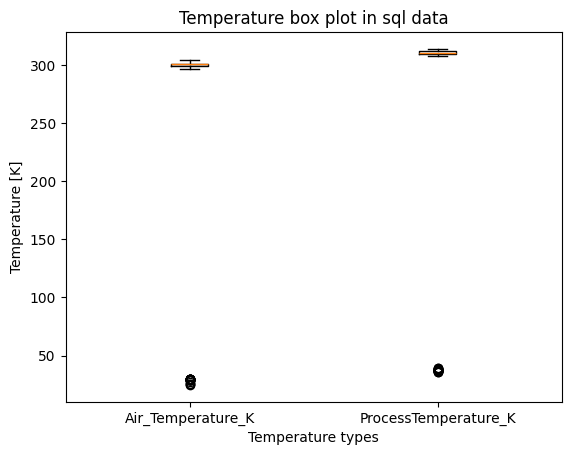

In [98]:
# draw box plot for temperature variable in sql data
idx = df_sql[['Air_Temperature_K', 'ProcessTemperature_K']].notnull()
plt.title('Temperature box plot in sql data')
plt.boxplot([
    df_sql['Air_Temperature_K'].loc[idx['Air_Temperature_K']],
    df_sql['ProcessTemperature_K'].loc[idx['ProcessTemperature_K']]
], 
tick_labels=['Air_Temperature_K', 'ProcessTemperature_K'])
plt.xlabel('Temperature types')
plt.ylabel('Temperature [K]')
plt.show()

In [99]:
df_sql[(df_sql['Air_Temperature_K']<100) | (df_sql['ProcessTemperature_K']<100) ]

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
5001,L47249,25.75,35.85,1410,65.7,191,1,0,0,1,1,0
5002,M16184,25.65,36.95,1243,74.5,194,1,0,0,1,1,0
5003,L48676,24.85,35.55,1268,69.4,189,1,0,0,1,1,0
5004,L50791,28.55,37.75,1405,46.4,207,1,1,0,0,0,1
5005,L51034,29.25,37.85,1338,67.6,194,1,0,0,1,1,0
5006,L51123,29.15,38.25,1333,66.7,205,1,0,0,1,1,0
5007,L51434,29.45,37.85,1284,68.0,114,1,0,1,1,0,0
5008,M19202,28.55,36.65,1284,68.2,111,1,0,1,1,0,0
5009,L51550,28.85,36.75,1308,57.6,197,1,0,1,0,1,0
5010,L51563,28.55,36.35,1298,65.5,229,1,0,1,0,1,0


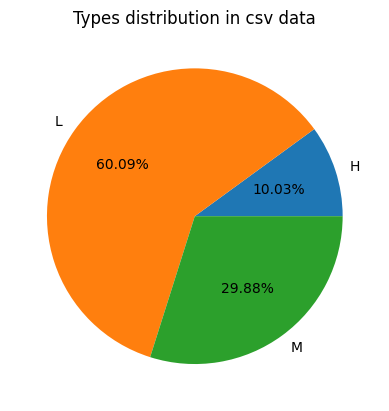

In [100]:
# draw pie dor type in csv data
cls, freq = np.unique(df_csv['Type'], return_counts=True)
plt.title('Types distribution in csv data')
plt.pie(freq, labels=cls, autopct='%1.2f%%')
plt.show()

In [101]:
df_sql.head()

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF
0,M19859,303.7,312.9,1532,41.3,32,0,0,0,0,0,0
1,L52180,303.7,312.8,1832,23.6,35,0,0,0,0,0,0
2,M19861,303.6,312.7,2174,17.6,37,0,0,0,0,0,0
3,L52182,303.7,312.8,1627,31.7,40,0,0,0,0,0,0
4,L52183,303.7,312.8,1437,51.3,42,0,0,0,0,0,0


In [102]:
# the type is in first position od the id
df_sql['Type'] = df_sql['ID'].str[0]
df_sql['Type'].unique()

array(['M', 'L', 'H'], dtype=object)

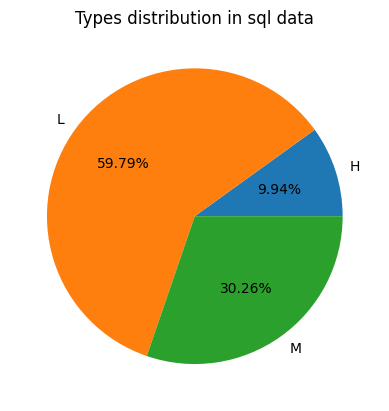

In [103]:
cls, freq = np.unique(df_sql['Type'], return_counts=True)
plt.title('Types distribution in sql data')
plt.pie(freq, labels=cls, autopct='%1.2f%%')
plt.show() 

In [104]:
# Apply PCA on "Air temperature", "Process temperature", "Rotational speed", "Torque" and "Tool wear"
# to get a two dimensional representation.
from sklearn.decomposition import PCA


idx = df_csv.iloc[:,2:7].notna().all(axis=1)
# select only the rows without NaN values in the selected columns
df_csv_nna = df_csv.iloc[df_csv[idx].index, 2:7]

pca2 = PCA(2)
df_csv_pca = pca2.fit_transform(df_csv_nna)
df_csv_pca.shape

(5968, 2)

Text(0.5, 1.0, 'PCA representation of csv data')

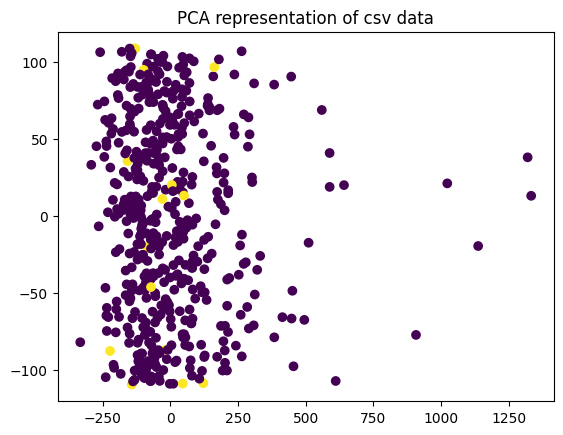

In [105]:
plt.scatter(df_csv_pca[:500,0], df_csv_pca[:500,1], c=df_csv['Machine failure'].iloc[:500])
plt.title('PCA representation of csv data')

In [106]:
idx = df_sql.iloc[:, 2:7].notna().all(axis=1)
df_sql_nna = df_sql.iloc[df_sql[idx].index, 2:7]

df_sql_pca = pca2.fit_transform(df_sql_nna)
df_sql_pca.shape

(5011, 2)

Text(0.5, 1.0, 'PCA representation of sql data')

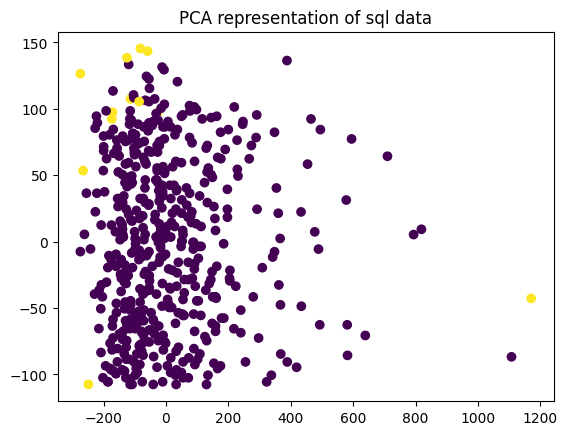

In [107]:
plt.scatter(df_sql_pca[:500,0], df_sql_pca[:500,1], c=df_sql['Failure'].iloc[:500])
plt.title('PCA representation of sql data')

### 2.4. Verifying data quality

In [108]:
df_csv[df_csv.isnull().any(axis=1)]

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M0000A,M,NaN,NaN,1551,NaN,0,0,NOT
1435,H30850,H,25.65,NaN,1510,44.2,35,0,NOT
2786,L49968,L,NaN,36.45,1326,52.4,57,0,NOT
2791,L49973,L,NaN,36.45,1597,31.8,73,0,NOT
2796,L49978,L,NaN,36.45,1568,39.6,85,0,NOT
2797,L49979,L,NaN,36.45,1404,44.6,87,0,NOT
2820,L50002,L,NaN,36.45,1593,38.1,140,0,NOT
5723,M20599,M,NaN,38.55,<NA>,31.4,2,0,NOT
5724,M20600,M,NaN,38.55,<NA>,38.3,5,0,NOT
5725,M20601,M,NaN,38.55,<NA>,40.5,8,0,NOT


In [109]:
df_sql[df_sql.isnull().any(axis=1)]

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF,Type
740,M20599,302.2,<NA>,1653,<NA>,2,0,0,0,0,0,0,M
741,M20600,302.3,<NA>,1535,<NA>,5,0,0,0,0,0,0,M
742,M20601,302.3,<NA>,1483,40.5,<NA>,0,0,0,0,0,0,M
743,L52922,302.3,<NA>,1414,47.0,<NA>,0,0,0,0,0,0,L
744,M20603,302.2,311.6,<NA>,<NA>,13,0,0,0,0,0,0,M
745,H35158,302.2,311.5,<NA>,<NA>,16,0,0,0,0,0,0,H
746,L52925,302.1,311.5,<NA>,<NA>,21,0,0,0,0,0,0,L
942,L53121,300.6,<NA>,1438,<NA>,78,1,0,0,0,0,0,L


In [110]:
df_csv[(df_csv['Machine failure'] == 0) & (df_csv['Failure type'] != 'NOT')]

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
1221,M16081,M,23.85,35.15,1399,46.4,132,0,RNF
1302,L48482,L,25.45,36.65,1505,45.7,144,0,RNF
1746,H31162,H,25.25,34.55,1626,31.1,166,0,RNF
2070,L49252,L,26.45,36.35,1570,35.5,189,0,RNF
2557,L49739,L,26.15,35.85,1447,50.4,140,0,RNF
3063,M17925,M,26.95,36.05,1687,27.7,95,0,RNF
3450,H32866,H,28.45,37.35,1602,32.3,2,0,RNF
5455,L52651,L,29.55,39.15,1346,61.2,170,0,RNF
5473,L52669,L,29.45,38.95,1499,35.0,215,0,RNF
5479,H34909,H,29.75,39.35,1357,55.0,12,0,RNF


In [111]:
err = df_sql['TWF'] + df_sql['HDF'] + df_sql['PWF'] + df_sql['OSF'] + df_sql['RNF']
df_sql[(df_sql['Failure'] == 0) & (err > 0)]

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF,Type
472,L52651,302.7,312.3,1346,61.2,170,0,0,0,0,0,1,L
490,L52669,302.6,312.1,1499,35.0,215,0,0,0,0,0,1,L
496,H34909,302.9,312.5,1357,55.0,12,0,0,0,0,0,1,H
510,L52689,302.8,312.2,1509,36.5,52,0,0,0,0,0,1,L
554,L52733,302.5,311.9,1306,59.7,172,0,0,0,0,0,1,L
640,L52819,302.6,312.1,1668,28.7,180,0,0,0,0,0,1,L
1092,L53271,300.9,310.7,1412,57.5,16,0,0,0,0,0,1,L
1914,L54093,300.8,311.2,1481,38.5,181,0,0,0,0,0,1,L
1961,L54140,300.7,311.0,1413,52.0,91,0,0,0,0,0,1,L
2489,L54668,300.3,311.7,1545,43.5,160,0,0,0,0,0,1,L


## 3. Data preparation

### 3.1. Selecting data

Do we need these features: "Product ID" and "Machine failure"? Why?
- "Product ID"?
    - Y|N
    - Why? ...
- "Machine failure"? 
    - Y|N 
    - Why? ...

### 3.2. Constructing new data 

In [112]:
# Transform Celsius into Kelvin for temperature : K = C + 273.15
df_csv['Air temperature [C]'] = df_csv['Air temperature [C]'] + 273.15
df_csv['Process temperature [C]'] = df_csv['Process temperature [C]'] + 273.15
df_csv.head()

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M0000A,M,NaN,NaN,1551,NaN,0,0,NOT
1,M14860,M,298.1,308.6,1551,42.8,0,0,NOT
2,L47181,L,298.2,308.7,1408,46.3,3,0,NOT
3,L47182,L,298.1,308.5,1498,49.4,5,0,NOT
4,L47183,L,298.2,308.6,1433,39.5,7,0,NOT


In [113]:
df_csv = pd.get_dummies(df_csv, columns=['Failure type'], dtype=int)
df_csv.head()

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type_HDF,Failure type_NOT,Failure type_OSF,Failure type_OTHER,Failure type_PWF,Failure type_RNF,Failure type_TWF
0,M0000A,M,NaN,NaN,1551,NaN,0,0,0,1,0,0,0,0,0
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,1,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,1,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,1,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,1,0,0,0,0,0


In [114]:
df_sql.head()

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF,Type
0,M19859,303.7,312.9,1532,41.3,32,0,0,0,0,0,0,M
1,L52180,303.7,312.8,1832,23.6,35,0,0,0,0,0,0,L
2,M19861,303.6,312.7,2174,17.6,37,0,0,0,0,0,0,M
3,L52182,303.7,312.8,1627,31.7,40,0,0,0,0,0,0,L
4,L52183,303.7,312.8,1437,51.3,42,0,0,0,0,0,0,L


In [115]:
df_sql['OTHER'] = other
df_sql.head()


,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF,Type,OTHER
0,M19859,303.7,312.9,1532,41.3,32,0,0,0,0,0,0,M,0
1,L52180,303.7,312.8,1832,23.6,35,0,0,0,0,0,0,L,0
2,M19861,303.6,312.7,2174,17.6,37,0,0,0,0,0,0,M,0
3,L52182,303.7,312.8,1627,31.7,40,0,0,0,0,0,0,L,0
4,L52183,303.7,312.8,1437,51.3,42,0,0,0,0,0,0,L,0


In [116]:
df_sql.head()

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF,Type,OTHER
0,M19859,303.7,312.9,1532,41.3,32,0,0,0,0,0,0,M,0
1,L52180,303.7,312.8,1832,23.6,35,0,0,0,0,0,0,L,0
2,M19861,303.6,312.7,2174,17.6,37,0,0,0,0,0,0,M,0
3,L52182,303.7,312.8,1627,31.7,40,0,0,0,0,0,0,L,0
4,L52183,303.7,312.8,1437,51.3,42,0,0,0,0,0,0,L,0


In [117]:
df_csv = pd.get_dummies(df_csv, columns=['Type'], dtype=int)
df_csv.head()


,Product ID,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type_HDF,Failure type_NOT,Failure type_OSF,Failure type_OTHER,Failure type_PWF,Failure type_RNF,Failure type_TWF,Type_H,Type_L,Type_M
0,M0000A,NaN,NaN,1551,NaN,0,0,0,1,0,0,0,0,0,0,0,1
1,M14860,298.1,308.6,1551,42.8,0,0,0,1,0,0,0,0,0,0,0,1
2,L47181,298.2,308.7,1408,46.3,3,0,0,1,0,0,0,0,0,0,1,0
3,L47182,298.1,308.5,1498,49.4,5,0,0,1,0,0,0,0,0,0,1,0
4,L47183,298.2,308.6,1433,39.5,7,0,0,1,0,0,0,0,0,0,1,0


In [118]:
df_sql = pd.get_dummies(df_sql, columns=['Type'], dtype=int)
df_sql.head()

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF,OTHER,Type_H,Type_L,Type_M
0,M19859,303.7,312.9,1532,41.3,32,0,0,0,0,0,0,0,0,0,1
1,L52180,303.7,312.8,1832,23.6,35,0,0,0,0,0,0,0,0,1,0
2,M19861,303.6,312.7,2174,17.6,37,0,0,0,0,0,0,0,0,0,1
3,L52182,303.7,312.8,1627,31.7,40,0,0,0,0,0,0,0,0,1,0
4,L52183,303.7,312.8,1437,51.3,42,0,0,0,0,0,0,0,0,1,0


### 3.3. Integrating data

In [119]:
df_csv.head()

,Product ID,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type_HDF,Failure type_NOT,Failure type_OSF,Failure type_OTHER,Failure type_PWF,Failure type_RNF,Failure type_TWF,Type_H,Type_L,Type_M
0,M0000A,NaN,NaN,1551,NaN,0,0,0,1,0,0,0,0,0,0,0,1
1,M14860,298.1,308.6,1551,42.8,0,0,0,1,0,0,0,0,0,0,0,1
2,L47181,298.2,308.7,1408,46.3,3,0,0,1,0,0,0,0,0,0,1,0
3,L47182,298.1,308.5,1498,49.4,5,0,0,1,0,0,0,0,0,0,1,0
4,L47183,298.2,308.6,1433,39.5,7,0,0,1,0,0,0,0,0,0,1,0


In [120]:
df_sql.head()

,ID,Air_Temperature_K,ProcessTemperature_K,Rotational_speed,Torque,Tool_wear,Failure,TWF,HDF,PWF,OSF,RNF,OTHER,Type_H,Type_L,Type_M
0,M19859,303.7,312.9,1532,41.3,32,0,0,0,0,0,0,0,0,0,1
1,L52180,303.7,312.8,1832,23.6,35,0,0,0,0,0,0,0,0,1,0
2,M19861,303.6,312.7,2174,17.6,37,0,0,0,0,0,0,0,0,0,1
3,L52182,303.7,312.8,1627,31.7,40,0,0,0,0,0,0,0,0,1,0
4,L52183,303.7,312.8,1437,51.3,42,0,0,0,0,0,0,0,0,1,0


In [121]:
d1_names = {
    'Product ID': 'ID',
    'Air temperature [C]': 'AirTemperature',
    'Process temperature [C]': 'ProcessTemperature',
    'Rotational speed [rpm]': 'RotationalSpeed',
    'Torque [Nm]': 'Torque',
    'Tool wear [min]': 'ToolWear',
    'Machine failure': 'Failure',
    'Failure type_HDF': 'HDF',
    'Failure type_OSF': 'OSF',
    'Failure type_OTHER': 'OTHER',
    'Failure type_PWF': 'PWF',
    'Failure type_RNF': 'RNF',
    'Failure type_TWF': 'TWF'
}

df_csv.rename(columns=d1_names, inplace=True)
df_csv.head()

,ID,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Failure,HDF,Failure type_NOT,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M
0,M0000A,NaN,NaN,1551,NaN,0,0,0,1,0,0,0,0,0,0,0,1
1,M14860,298.1,308.6,1551,42.8,0,0,0,1,0,0,0,0,0,0,0,1
2,L47181,298.2,308.7,1408,46.3,3,0,0,1,0,0,0,0,0,0,1,0
3,L47182,298.1,308.5,1498,49.4,5,0,0,1,0,0,0,0,0,0,1,0
4,L47183,298.2,308.6,1433,39.5,7,0,0,1,0,0,0,0,0,0,1,0


In [122]:
d2_names = {
	'Air_Temperature_K': 'AirTemperature',
    'ProcessTemperature_K': 'ProcessTemperature',
    'Rotational_speed': 'RotationalSpeed',
    'Tool_wear': 'ToolWear'
}
df_sql.rename(columns=d2_names, inplace=True)
df_sql.head()

,ID,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Failure,TWF,HDF,PWF,OSF,RNF,OTHER,Type_H,Type_L,Type_M
0,M19859,303.7,312.9,1532,41.3,32,0,0,0,0,0,0,0,0,0,1
1,L52180,303.7,312.8,1832,23.6,35,0,0,0,0,0,0,0,0,1,0
2,M19861,303.6,312.7,2174,17.6,37,0,0,0,0,0,0,0,0,0,1
3,L52182,303.7,312.8,1627,31.7,40,0,0,0,0,0,0,0,0,1,0
4,L52183,303.7,312.8,1437,51.3,42,0,0,0,0,0,0,0,0,1,0


In [123]:
data = pd.concat([df_csv, df_sql])
data.head()

,ID,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Failure,HDF,Failure type_NOT,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M
0,M0000A,NaN,<NA>,1551,<NA>,0,0,0,1.0,0,0,0,0,0,0,0,1
1,M14860,298.1,308.6,1551,42.8,0,0,0,1.0,0,0,0,0,0,0,0,1
2,L47181,298.2,308.7,1408,46.3,3,0,0,1.0,0,0,0,0,0,0,1,0
3,L47182,298.1,308.5,1498,49.4,5,0,0,1.0,0,0,0,0,0,0,1,0
4,L47183,298.2,308.6,1433,39.5,7,0,0,1.0,0,0,0,0,0,0,1,0


### 3.4. Cleaning data

In [124]:
idx = data[(data['Failure'] == 0) & (data['HDF'] + data['TWF'] + data['PWF'] + data['OSF'] + data['RNF'] > 0)]
idx
data.drop(idx.index, axis=0, inplace=True)
data.head()

,ID,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Failure,HDF,Failure type_NOT,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M
0,M0000A,NaN,<NA>,1551,<NA>,0,0,0,1.0,0,0,0,0,0,0,0,1
1,M14860,298.1,308.6,1551,42.8,0,0,0,1.0,0,0,0,0,0,0,0,1
2,L47181,298.2,308.7,1408,46.3,3,0,0,1.0,0,0,0,0,0,0,1,0
3,L47182,298.1,308.5,1498,49.4,5,0,0,1.0,0,0,0,0,0,0,1,0
4,L47183,298.2,308.6,1433,39.5,7,0,0,1.0,0,0,0,0,0,0,1,0


In [125]:
dup = data[data.duplicated('ID', keep=False)]
dup


,ID,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Failure,HDF,Failure type_NOT,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M
4985,M19859,303.70,312.9,1532,41.3,32,0,0,1.0,0,0,0,0,0,0,0,1
4986,L52180,303.70,312.8,1832,23.6,35,0,0,1.0,0,0,0,0,0,0,1,0
4987,M19861,303.60,312.7,2174,17.6,37,0,0,1.0,0,0,0,0,0,0,0,1
4988,L52182,303.70,312.8,1627,31.7,40,0,0,1.0,0,0,0,0,0,0,1,0
4989,L52183,303.70,312.8,1437,51.3,42,0,0,1.0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,M20858,300.40,310.2,1613,36.9,231,0,0,NaN,0,0,0,0,0,0,0,1
1000,M20859,300.40,310.2,1671,30.5,234,1,0,NaN,0,0,0,0,1,0,0,1
5016,M20254,29.65,39.15,1262,70.5,234,1,0,NaN,1,0,1,0,0,0,0,1
5017,M20261,29.45,39.15,1454,54.8,253,1,0,NaN,1,0,0,0,1,0,0,1


In [126]:
dup.isna().sum()

ID                      0
AirTemperature          5
ProcessTemperature      8
RotationalSpeed         8
Torque                  6
ToolWear                5
Failure                 0
HDF                     0
Failure type_NOT      998
OSF                     0
OTHER                   0
PWF                     0
RNF                     0
TWF                     0
Type_H                  0
Type_L                  0
Type_M                  0
dtype: int64

In [127]:
data.update(data.groupby('ID').ffill())
data.update(data.groupby('ID').bfill())

dup = data[data.duplicated('ID', keep=False)]
dup.isna().sum()

ID                    0
AirTemperature        0
ProcessTemperature    0
RotationalSpeed       0
Torque                0
ToolWear              0
Failure               0
HDF                   0
Failure type_NOT      6
OSF                   0
OTHER                 0
PWF                   0
RNF                   0
TWF                   0
Type_H                0
Type_L                0
Type_M                0
dtype: int64

In [128]:
data.drop_duplicates('ID', keep='last', inplace=True)
data[data.duplicated('ID', keep=False)]

,ID,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Failure,HDF,Failure type_NOT,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M


In [129]:
# create a not column for not failure
data['NOT'] = 1 - data['Failure']
data.head()

,ID,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Failure,HDF,Failure type_NOT,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M,NOT
0,M0000A,NaN,<NA>,1551,<NA>,0,0,0,1.0,0,0,0,0,0,0,0,1,1
1,M14860,298.1,308.6,1551,42.8,0,0,0,1.0,0,0,0,0,0,0,0,1,1
2,L47181,298.2,308.7,1408,46.3,3,0,0,1.0,0,0,0,0,0,0,1,0,1
3,L47182,298.1,308.5,1498,49.4,5,0,0,1.0,0,0,0,0,0,0,1,0,1
4,L47183,298.2,308.6,1433,39.5,7,0,0,1.0,0,0,0,0,0,0,1,0,1


In [130]:
data.drop(columns=['ID','Failure', 'Failure type_NOT'], inplace=True)
data.head()

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,HDF,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M,NOT
0,NaN,<NA>,1551,<NA>,0,0,0,0,0,0,0,0,0,1,1
1,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0,0,1,1
2,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0,1,0,1
3,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0,1,0,1
4,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0,1,0,1


In [131]:
# If a sample has more than a missing value, delete it
idx = data.isna().sum(axis=1) > 1
print('number of samples with more than one missing value (before)', idx.sum())
data.drop(data[idx].index, axis=0, inplace=True)

idx = data.isna().sum(axis=1) > 1
print('number of samples with more than one missing value (after)', idx.sum())

number of samples with more than one missing value (before) 1
number of samples with more than one missing value (after) 0


In [132]:
data.isna().sum()

AirTemperature        5
ProcessTemperature    1
RotationalSpeed       0
Torque                0
ToolWear              0
HDF                   0
OSF                   0
OTHER                 0
PWF                   0
RNF                   0
TWF                   0
Type_H                0
Type_L                0
Type_M                0
NOT                   0
dtype: int64

In [133]:
data['AirTemperature'] = data.groupby(['Type_L', 'Type_M', 'Type_H'])['AirTemperature'].transform(lambda x: x.fillna(x.mean()))
data['ProcessTemperature'] = data.groupby(['Type_L', 'Type_M', 'Type_H'])['ProcessTemperature'].transform(lambda x: x.fillna(x.mean()))

data.isna().sum()

AirTemperature        0
ProcessTemperature    0
RotationalSpeed       0
Torque                0
ToolWear              0
HDF                   0
OSF                   0
OTHER                 0
PWF                   0
RNF                   0
TWF                   0
Type_H                0
Type_L                0
Type_M                0
NOT                   0
dtype: int64

### 3.5. Formatting data and Constructing new data

In [134]:
data.head()

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,HDF,OSF,OTHER,PWF,RNF,TWF,Type_H,Type_L,Type_M,NOT
1,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0,0,1,1
2,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0,1,0,1
3,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0,1,0,1
4,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0,1,0,1
5,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0,1,0,1


In [135]:
# If a class has less than 10 samples, consider it as "OTHER".
cls = ['HDF', 'OSF', 'PWF', 'RNF', 'TWF']
drp = []
for c in cls:
    if data[c].sum() < 10:
        data['OTHER'] = ((data['OTHER']+data[c]) > 0).astype(int)
        drp.append(c)
data.drop(columns=drp, inplace=True)
data

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,HDF,OSF,OTHER,PWF,TWF,Type_H,Type_L,Type_M,NOT
1,298.10,308.6,1551,42.8,0,0,0,0,0,0,0,0,1,1
2,298.20,308.7,1408,46.3,3,0,0,0,0,0,0,1,0,1
3,298.10,308.5,1498,49.4,5,0,0,0,0,0,0,1,0,1
4,298.20,308.6,1433,39.5,7,0,0,0,0,0,0,1,0,1
5,298.20,308.7,1408,40.0,9,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,30.05,38.25,1324,54.2,228,1,1,0,0,0,0,1,0,0
5015,30.25,38.65,1306,61.0,215,1,1,0,0,0,0,1,0,0
5016,29.65,39.15,1262,70.5,234,0,1,0,1,0,0,0,1,0
5017,29.45,39.15,1454,54.8,253,0,1,0,0,1,0,0,1,0


In [138]:
print(drp)

['RNF']


In [136]:
# Put the classes at the end so we can select them easily
idx = idx = ['RotationalSpeed', 'Torque','ToolWear', 'AirTemperature', 'ProcessTemperature',
'Type_H', 'Type_L', 'Type_M',
'HDF', 'OSF', 'OTHER', 'PWF', 'TWF', 'NOT']

data = data.reindex(idx, axis=1)
data.head()

,RotationalSpeed,Torque,ToolWear,AirTemperature,ProcessTemperature,Type_H,Type_L,Type_M,HDF,OSF,OTHER,PWF,TWF,NOT
1,1551,42.8,0,298.1,308.6,0,0,1,0,0,0,0,0,1
2,1408,46.3,3,298.2,308.7,0,1,0,0,0,0,0,0,1
3,1498,49.4,5,298.1,308.5,0,1,0,0,0,0,0,0,1
4,1433,39.5,7,298.2,308.6,0,1,0,0,0,0,0,0,1
5,1408,40.0,9,298.2,308.7,0,1,0,0,0,0,0,0,1


In [137]:
# Split data into input and output
X = data.iloc[:, :-6].to_numpy()
y = data.iloc[:, -6:].to_numpy()
X.shape, y.shape

((9963, 8), (9963, 6))

In [141]:
y.sum(axis=0)

array([ 115,   98,   10,   95,   46, 9624])

In [143]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6974, 8), (2989, 8), (6974, 6), (2989, 6))

In [148]:
y_train.sum(axis=0)

array([  86,   70,    7,   63,   33, 6732])

In [151]:
# Convert binary array to class single label
def bin2cls(tab):
    p=1
    r=0
    for t in tab:
        r+= t*p
        p*=2
    return r
bin2cls([1, 0, 0, 1, 0, 0, 1])

73

In [165]:
# Convert class single label to binary array (reverse of bin2csl)
def cls2bin(n, l):
    r = []
    p = 2
    while n:
        n, m = divmod(n, p)
        r = [m] + r
    if len(r) < l:
        r = r + ([0] * (l - len(r)))
    return r

cls2bin(73, l=7)

[1, 0, 0, 1, 0, 0, 1]

In [170]:
YY = np.array(list(map(bin2cls, y_train)))
ncls, count = np.unique(YY, return_counts=True)
ncls, count

(array([ 1,  2,  3,  4,  8,  9, 10, 16, 18, 20, 32]),
 array([  78,   57,    5,    6,   53,    3,    7,   31,    1,    1, 6732]))

In [154]:
ncls10 = ncls[count >= 10]
ncls10

array([ 1,  2,  8, 16, 32])

In [155]:
idx10 = np.isin(YY, ncls10)
idx10.shape, YY.shape

((6974,), (6974,))

In [159]:
# Apply the oversampling SMOTE on training dataset to get a new one
# (on the classes with more than 10 samples).
X_smote, y_smote = SMOTE().fit_resample(X_train[idx10,:], YY[idx10])
X_smote.shape, y_smote.shape

((33660, 8), (33660,))

In [160]:
# add other classes
X_smote = np.concatenate([X_smote, X_train[~idx10,:]], axis=0)
y_smote = np.concatenate([y_smote, YY[~idx10]], axis=0)
X_smote.shape, y_smote.shape

((33683, 8), (33683,))

In [166]:
y_smote = np.array(list(map(lambda n: cls2bin(n, l=y_train.shape[1]), y_smote)))
y_smote.shape

(33683, 6)

In [173]:
# Apply two undersampling techniques on the majority
# ClusterCentroids 
# the majority class (c=32) having 6732 samples will have 200 samples
X_cc, y_cc = ClusterCentroids(sampling_strategy={32:200}).fit_resample(X_train[idx10,:], YY[idx10])
X_cc.shape, y_cc.shape

((419, 8), (419,))

In [174]:
y_cc = np.array(list(map(lambda n: cls2bin(n, l=y_train.shape[1]), y_cc)))
y_cc.shape

(419, 6)

In [176]:
# TomekLinks
X_tl, y_tl = TomekLinks(sampling_strategy=[32]).fit_resample(X_train[idx10,:], YY[idx10])
X_tl.shape, y_tl.shape

((6879, 8), (6879,))

In [177]:
y_tl = np.array(list(map(lambda n: cls2bin(n, l=y_train.shape[1]), y_tl)))
y_tl.shape

(6879, 6)

In [179]:
# Apply normalization on the 4 past datasets to get three new ones.
# In this case, we will have 8 training datasets: 
# No\_sampling, No\_sampling\_normalized, SMOTE, SMOTE\_normalized, ClusterCentroids, 
# ClusterCentroids\_normalized, TomekLinks and TomekLinks\_normalized.
from sklearn.preprocessing import StandardScaler

plain_norm = StandardScaler()
smote_norm = StandardScaler()
cc_norm = StandardScaler()
tl_norm = StandardScaler()

X_train_norm = plain_norm.fit_transform(X_train)
X_train_smote_norm = smote_norm.fit_transform(X_smote)
X_train_cc_norm = cc_norm.fit_transform(X_cc)
X_train_tl_norm = tl_norm.fit_transform(X_tl)

X_train_norm[0, :], X_train_smote_norm[0, :], X_train_cc_norm[0, :], X_train_tl_norm[0, :]

(array([ 0.44702912, -0.7219019 ,  0.79843263,  0.27265289,  0.22392071,
        -0.33136486, -1.23490157,  1.53812552]),
 array([ 0.36243788, -0.9790609 ,  0.18078558,  0.40605798,  0.37436798,
        -0.34171138, -1.58244914,  1.93698156]),
 array([-0.65207191,  0.41117142,  0.28318897,  1.26897344,  0.03904425,
        -0.43175302,  1.00671318, -0.84087111]),
 array([ 0.44259151, -0.71512603,  0.80809089,  1.40636203,  1.48726238,
        -0.33093221, -1.23729749,  1.54068576]))

In [180]:
# Apply the same normalization on test dataset to get 4 test datasets

X_test_norm = plain_norm.transform(X_test)
X_test_smote_norm = smote_norm.transform(X_test)
X_test_cc_norm = cc_norm.transform(X_test)
X_test_tl_norm = tl_norm.transform(X_test)

X_test_norm[0, :], X_test_smote_norm[0, :], X_test_cc_norm[0, :], X_test_tl_norm[0, :]

(array([-1.05870152,  0.40405241,  1.536012  ,  0.04501643,  0.14250603,
        -0.33136486,  0.80978114, -0.650142  ]),
 array([-0.46657815, -0.22547877,  0.85444172, -0.07309786,  0.19870588,
        -0.34171138,  0.8080846 , -0.67484974]),
 array([-0.58429174, -0.01464816,  1.1111347 , -0.3021085 ,  1.01709462,
        -0.43175302,  1.00671318, -0.84087111]),
 array([-1.07938491,  0.42565231,  1.54825137,  0.00787182,  0.81429342,
        -0.33093221,  0.80821307, -0.64906162]))

## 4. Modeling and Evaluation

In [185]:
l= y_train.shape[1]

In [186]:
def multilabe_model_train_test(mdls, xtrain, xtest, ytrain, ytest):
    r = []
    t = timeit.default_timer()
    for i in range(l):
        mdls[i].fit(xtrain, ytrain[:, i])
    t = timeit.default_timer() - t
    r.append(t)

    tt = 0.
    aa = 0.
    for i in range(l):
        t = timeit.default_timer()
        ys = mdls[i].predict(xtest)
        tt += timeit.default_timer() - t
        aa += accuracy_score(ytest[:, i], ys)

    r.append(tt)

    a = 0.
    for i in range(l):
        a += accuracy_score(ytrain[:, i], mdls[i].predict(xtrain))
    
    r.append(a/l)
    r.append(aa/l)
    return r

In [187]:
# Logistic regression with L2 penalization (by default) and "liblinear" solver.
results = {
    'Metrics': ['Train time', 'Test time', 'Train Accuracy', 'Test Accuracy']
}

datasets = [
    ('plain', X_train, X_test, y_train, y_test),
    ('plain-norm', X_train_norm, X_test_norm, y_train, y_test),
    ('smote', X_smote, X_test, y_smote, y_test),
    ('smote-norm', X_train_smote_norm, X_test_norm, y_smote, y_test),
    ('cc', X_cc, X_test, y_cc, y_test),
    ('cc-norm', X_train_cc_norm, X_test_norm, y_cc, y_test),
    ('tl', X_tl, X_test, y_tl, y_test),
    ('tl-norm', X_train_tl_norm, X_test_norm, y_tl, y_test),
]

for name, xtrain, xtest, ytrain, ytest in datasets:
    results['LR-' + name] = multilabe_model_train_test(
        [LogisticRegression(solver='liblinear') for _ in range(l)], X_train, X_test, y_train, y_test
    )
    results['GNB-' + name] = multilabe_model_train_test(
        [GaussianNB() for _ in range(l)], X_train, X_test, y_train, y_test
    )
    results['CART-' + name] = multilabe_model_train_test(
        [DecisionTreeClassifier() for _ in range(l)], X_train, X_test, y_train, y_test
    )
    results['RF-' + name] = multilabe_model_train_test(
        [RandomForestClassifier(n_estimators=50) for _ in range(l)], X_train, X_test, y_train, y_test
    )

pd.DataFrame(results).transpose()

,0,1,2,3
Metrics,Train time,Test time,Train Accuracy,Test Accuracy
LR-plain,0.267078,0.015162,0.989485,0.990632
GNB-plain,0.051888,0.015921,0.988003,0.989629
CART-plain,0.168067,0.013989,1.0,0.992751
RF-plain,2.547711,0.091631,0.999928,0.993699
LR-plain-norm,0.247147,0.012165,0.989485,0.990632
GNB-plain-norm,0.047206,0.016742,0.988003,0.989629
CART-plain-norm,0.152769,0.012389,1.0,0.992528
RF-plain-norm,2.470573,0.095023,0.999976,0.993532
LR-smote,0.260529,0.015357,0.989485,0.990632
